In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi32')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Projections have already been applied. Setting proj attribute to True.


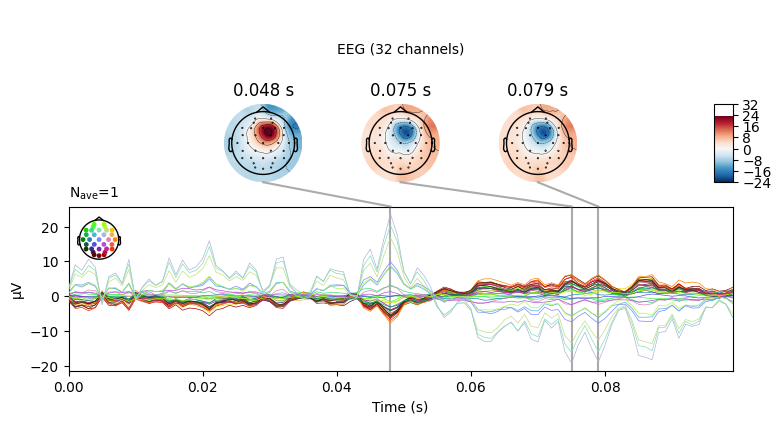

In [7]:
settings = dict(number_of_sources=3, extents=25, duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
evoked.plot_joint()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1992.54it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 200.52it/s]

Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


Using control points [2.20259278e-11 9.28159350e-10 1.85479298e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


In [23]:
from invert.solvers.matching_pursuit import SolverSOMP, SolverCOSAMP
from invert.solvers.minimum_norm_estimates import SolverMinimumL1Norm

solver = SolverSOMP()
# solver = SolverMinimumL1Norm()
solver.make_inverse_operator(fwd)
stc_ = solver.apply_inverse_operator(evoked)
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

Using control points [0.00000000e+00 0.00000000e+00 9.33881343e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\util\util.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  return 100 * np.sum( (M-M_hat)**2 ) / np.sum(M**2)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.00000000e+00 0.00000000e+00 1.15580844e-09]
Using control points [0.00000000e+00 0.00000000e+00 3.74902319e-10]


In [ ]:
from invert import Solver
from invert.config import all_solvers
from invert.evaluate import nmse, corr
from invert.adapters import contextualize_bd
import pickle as pkl

if "LUCAS" in all_solvers:
    all_solvers.remove("LUCAS")
if "Multiple Sparse Priors" in all_solvers:
    all_solvers.remove("Multiple Sparse Priors")
if "Backus-Gilbert" in all_solvers:
    all_solvers.remove("Backus-Gilbert")
if "Fully-Connected" in all_solvers:
    all_solvers.remove("Fully-Connected")

settings = dict(number_of_sources=(1,10), extents=(1, 40), duration_of_trial=1, target_snr=(1,25))
errors = {sname: [] for sname in all_solvers}
# solvers = dict()

for i in range(5):
    # print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or ("sparse" in solver_name.lower() or "bayes" in solver_name.lower()):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        error = np.mean(corr(abs(stc.data), abs(stc_hat.data)))
        
        errors[solver_name].append( error )
        
        # Add temporal Contextualization (CMNE-type)
        # solver_name = "c" + solver_name
        # if not solver_name in errors:
        #     errors[solver_name] = []
        # stc_hat = contextualize_bd(stc_hat, fwd, fast=True)
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        # errors[solver_name].append( error )



    # if i > 22:
    #     fn = "errors.pkl"
    #     with open(fn, 'wb') as f:
    #         pkl.dump(errors, f)

In [8]:
from invert import Solver
from invert.config import all_solvers
from invert.evaluate import corr

if "LUCAS" in all_solvers:
    all_solvers.remove("LUCAS")
# if "Multiple Sparse Priors" in all_solvers:
#     all_solvers.remove("Multiple Sparse Priors")
if "Backus-Gilbert" in all_solvers:
    all_solvers.remove("Backus-Gilbert")
if "Fully-Connected" in all_solvers:
    all_solvers.remove("Fully-Connected")
    
settings = dict(number_of_sources=(1,10), extents=(1, 40), duration_of_trial=1, target_snr=(1,25))
errors = {sname: [] for sname in all_solvers}
solvers = dict()

for solver_name in all_solvers:
    print(solver_name)
    solver = Solver(solver=solver_name)
    solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
    stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
    stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
    # error = np.mean(corr(stc.data, stc_hat.data))
    error = np.mean(corr(abs(stc.data), abs(stc_hat.data)))
    
    errors[solver_name].append( error )

MNE
Using control points [2.81595382e-10 3.39325092e-10 8.23334532e-10]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
wMNE
Using control points [8.16602315e-14 9.21803668e-14 1.54167636e-13]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
dSPM
Using control points [8.01722809e-06 9.37903922e-06 1.99093086e-05]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
LORETA
Using control points [1.33676660e-09 1.58314375e-09 3.29838397e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
sLORETA
Using control points [3.96228516e-09 4.76824231e-09 1.10289280e-08]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
eLORETA
Using control points [5.67481091e-10 7.07146667e-10 2.14759844e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
LAURA
Using control points [3.85610447e-10 4.82161357e-10 1.39849856e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
S-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


Using control points [1.22034705e-09 1.45484877e-09 2.77757080e-09]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Champagne


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\sparse\_dia.py:338: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


Using control points [0. 0. 0.]


C:\Users\Lukas\AppData\Local\Temp\ipykernel_13644\733435240.py:23: RuntimeWarning: All data were zero
  stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Bayesian LORETA
Using control points [4.79089145e-10 5.88899236e-10 1.51658563e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Bayesian MNE
Using control points [4.60341058e-10 5.67705770e-10 1.51035446e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Bayesian Beamformer
Using control points [5.94128204e-09 8.97643962e-09 8.78087300e-08]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Bayesian Beamformer LORETA
Using control points [7.61329509e-10 9.44885124e-10 2.02851522e-09]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:104: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
FISTA
Using control points [6.01964788e-10 8.38513669e-10 3.31535662e-09]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:134: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


Using control points [0.00000000e+00 0.00000000e+00 6.34067779e-06]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
SOMP
Using control points [0.00000000e+00 0.00000000e+00 2.33946532e-08]


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\util\util.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  return 100 * np.sum( (M-M_hat)**2 ) / np.sum(M**2)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.00000000e+00 0.00000000e+00 3.57574745e-08]
Using control points [1.32467837e-09 1.70380892e-09 5.20042035e-09]
Using control points [1.06665161e-09 1.24510270e-09 2.66386163e-09]
Using control points [9.71986070e-10 1.28808806e-09 1.95516384e-09]


In [ ]:
import pickle as pkl
fn = "errors.pkl"
with open(fn, 'rb') as f:
    errors = pkl.load(f)

In [13]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
df = pd.DataFrame(errors)
sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


,Median,Variance,MedVar,Method
SOMP,-0.007117,NaN,NaN,SOMP
COSAMP,0.012885,NaN,NaN,COSAMP
wMNE,0.016130,NaN,NaN,wMNE
Multiple Sparse Priors,0.074649,NaN,NaN,Multiple Sparse Priors
dSPM,0.114922,NaN,NaN,dSPM
Bayesian Beamformer,0.153138,NaN,NaN,Bayesian Beamformer
MNE,0.170324,NaN,NaN,MNE
FISTA,0.175212,NaN,NaN,FISTA
Bayesian MNE,0.197601,NaN,NaN,Bayesian MNE
Bayesian LORETA,0.226343,NaN,NaN,Bayesian LORETA


Text(0, 0.5, 'Variance')

In [29]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


source data shape:  (1284, 25) (1284, 25)


100%|██████████| 2/2 [00:00<00:00, 401.10it/s]

Using control points [7.65419547e-12 2.74940874e-10 8.61962362e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


In [30]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")

Using control points [0.00000000e+00 0.00000000e+00 6.66902285e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
1/1 [==============================] - 0s 15ms/step
Using control points [1.02043274e-09 1.23855303e-09 3.65582625e-09]


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Champ: 0.49981637890587544
FC: 0.15080562482670634
